# Manipulating kernels


GPflow comes with a range of kernels. In this notebook, we examine some of them, show how you can combine them to make new kernels, and discuss the `active_dims` feature.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import tensorflow as tf

%matplotlib inline

## Standard kernels in GPflow

GPflow comes with lots of standard kernels. Some very simple kernels produce constant functions, linear functions, and white noise functions:

 * `gpflow.kernels.Constant`

 * `gpflow.kernels.Linear`

 * `gpflow.kernels.White`

Some stationary functions produce samples with varying degrees of smoothness:

 * `gpflow.kernels.Exponential`

 * `gpflow.kernels.Matern12`

 * `gpflow.kernels.Matern32`

 * `gpflow.kernels.Matern52`

 * `gpflow.kernels.SquaredExponential` (also known as `gpflow.kernels.RBF`)

 * `gpflow.kernels.RationalQuadratic`

Two kernels produce periodic samples:

 * `gpflow.kernels.Cosine`

 * `gpflow.kernels.Periodic`

Other kernels that are implemented in core GPflow include:

 * `gpflow.kernels.Polynomial`

 * `gpflow.kernels.ArcCosine` ("neural network kernel")

 * `gpflow.kernels.Coregion`

Let's define some plotting utils functions and have a look at samples from the prior for some of them:

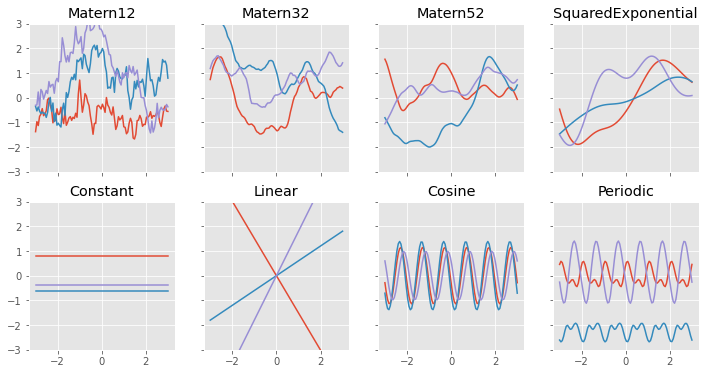

In [2]:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:, None]
    K = k(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)


np.random.seed(27)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(gpflow.kernels.Matern12(), axes[0, 0])
plotkernelsample(gpflow.kernels.Matern32(), axes[0, 1])
plotkernelsample(gpflow.kernels.Matern52(), axes[0, 2])
plotkernelsample(gpflow.kernels.RBF(), axes[0, 3])
plotkernelsample(gpflow.kernels.Constant(), axes[1, 0])
plotkernelsample(gpflow.kernels.Linear(), axes[1, 1])
plotkernelsample(gpflow.kernels.Cosine(), axes[1, 2])
plotkernelsample(gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential()), axes[1, 3])
_ = axes[0, 0].set_ylim(-3, 3)

## First example: create a Matern 3/2 covariance kernel

Many kernels have hyperparameters, for example `variance` and `lengthscales`. You can change the value of these parameters from their default value of `1.0`.

In [3]:
k = gpflow.kernels.Matern32(variance=10.0, lengthscales=2)

**NOTE:** The values specified for the `variance` and `lengthscales` parameters are **floats**.

To get information about the kernel, use `print_summary(k)` (plain text) or, in a notebook, pass the option `fmt="notebook"` to obtain a nicer rendering:

In [4]:
from gpflow.utilities import print_summary

print_summary(k)
print_summary(k, fmt="notebook")
# You can change the default format as follows:
gpflow.config.set_default_summary_fmt("notebook")
print_summary(k)

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Matern32.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │      10 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Matern32.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       2 │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,10
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,2


name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,10
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,2


You can access the parameter values and assign new values with the same syntax as for models:

In [5]:
print(k.lengthscales)
k.lengthscales.assign(0.5)
print(k.lengthscales)

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=2.0>
<Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.5>


Finally, you can *call* the kernel object to compute covariance matrices:

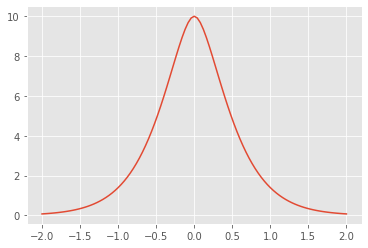

In [6]:
X1 = np.array([[0.0]])
X2 = np.linspace(-2, 2, 101).reshape(-1, 1)

K21 = k(X2, X1)  # cov(f(X2), f(X1)): matrix with shape [101, 1]
K22 = k(X2)  # equivalent to k(X2, X2) (but more efficient): matrix with shape [101, 101]

# plotting
plt.figure()
_ = plt.plot(X2, K21)

## Combine kernels
Sums and products of kernels are also valid kernels.
You can add or multiply instances of kernels to create a new composite kernel with the parameters of the old ones:

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1


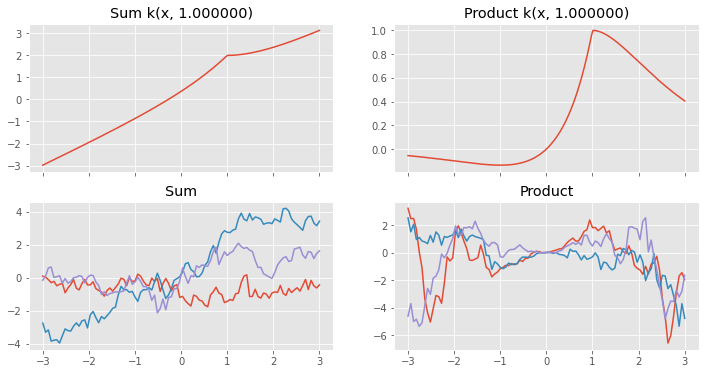

In [7]:
k1 = gpflow.kernels.Matern12()
k2 = gpflow.kernels.Linear()

k3 = k1 + k2
k4 = k1 * k2

print_summary(k3)
print_summary(k4)


def plotkernelfunction(k, ax, xmin=-3, xmax=3, other=0):
    xx = np.linspace(xmin, xmax, 200)[:, None]
    ax.plot(xx, k(xx, np.zeros((1, 1)) + other))
    ax.set_title(k.__class__.__name__ + " k(x, %f)" % other)


f, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
plotkernelfunction(k3, axes[0, 0], other=1.0)
plotkernelfunction(k4, axes[0, 1], other=1.0)
plotkernelsample(k3, axes[1, 0])
plotkernelsample(k4, axes[1, 1])

## Kernels for higher-dimensional input spaces

Kernels generalize to multiple dimensions straightforwardly. Stationary kernels support "Automatic Relevance Determination" (ARD), that is, having a different lengthscale parameter for each input dimension. Simply pass in an array of the same length as the number of input dimensions. **NOTE:** This means that the kernel object is then able to process only inputs of that dimension!

You can also initialize the lengthscales when the object is created:

In [8]:
k = gpflow.kernels.Matern52(lengthscales=[0.1, 0.2, 5.0])
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Matern52.variance,Parameter,Softplus,,True,(),float64,1.0
Matern52.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.1 0.2 5. ]


## Specify active dimensions

When combining kernels, it's often helpful to have bits of the kernel working on different dimensions. For example, to model a function that is linear in the first dimension and smooth in the second, we could use a combination of Linear and Matern52 kernels, one for each dimension.

To tell GPflow which dimension a kernel applies to, specify a list of integers as the value of the `active_dims` parameter.

In [9]:
k1 = gpflow.kernels.Linear(active_dims=[0])
k2 = gpflow.kernels.Matern52(active_dims=[1])
k = k1 + k2

`active_dims` makes it easy to create additive models. Here we build an additive Matern 5/2 kernel:

In [10]:
k = gpflow.kernels.Matern52(active_dims=[0], lengthscales=2) + gpflow.kernels.Matern52(
    active_dims=[1], lengthscales=2
)

Let's plot this kernel and sample from it:

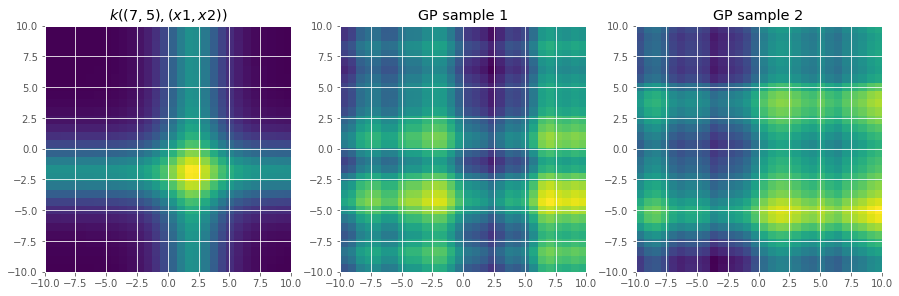

In [11]:
n_grid = 30
x = np.linspace(-10, 10, n_grid)
X, Y = np.meshgrid(x, x)
X = np.vstack((X.flatten(), Y.flatten())).T

x0 = np.array([[2.0, 2.0]])
# plot the kernel
KxX = k(X, x0).numpy().reshape(n_grid, n_grid)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(KxX, extent=[-10, 10, -10, 10])
axes[0].set_title(f"$k((7, 5), (x1, x2))$")

# plot a GP sample
K = k(X).numpy()
Z = np.random.multivariate_normal(np.zeros(n_grid ** 2), K, 2)
axes[1].imshow(Z[0, :].reshape(n_grid, n_grid), extent=[-10, 10, -10, 10])
axes[1].set_title("GP sample 1")
axes[2].imshow(Z[1, :].reshape(n_grid, n_grid), extent=[-10, 10, -10, 10])
_ = axes[2].set_title("GP sample 2")

## Define new covariance functions

GPflow makes it easy to define new covariance functions. See [Kernel design](../tailor/kernel_design.ipynb) for more information.